In [115]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
import matplotlib as mpl

This file presents the sanity check.

We use 10 users and 10 restaurants along with 37 ratings that connect the two.

In the cell bellow we read the data that we need from the csvs and preprocess it.

In [199]:
user_data = pd.read_csv("data/userprofile.csv", usecols = ["drink_level", "smoker", "personality", "activity", "interest"])
restaurant_data = pd.read_csv("data/geoplaces2.csv", usecols = ["alcohol", "smoking_area", "dress_code", "price", "area"])
restaurant_id = pd.read_csv("data/geoplaces2.csv", usecols = ["placeID"])
restaurant_name = pd.read_csv("data/geoplaces2.csv", usecols = ["name"])
ratings_data = pd.read_csv("data/rating.csv", usecols = ["userID", "placeID", "rating"])

restaurants = np.array(restaurant_data[:10].values.tolist())
ids = np.array(restaurant_id[:10].values.tolist()).flatten()
names = np.array(restaurant_name[:10].values.tolist()).flatten()
users = np.array(user_data[:10].values.tolist())
ratings = ratings_data.values.tolist()

no_users = len(users)
no_rest = len(restaurants)
no_ratings = len(ratings)
no_latent_factors = 5

unique_users = np.unique(users.flatten())
unique_rest = np.unique(restaurants.flatten())

users_features = []
for user in users:
    item_list = []
    for item in user:
        for index in range(len(unique_users)):
            if item == unique_users[index]:
                item_list.append(index)
    users_features.append(item_list)

rest_features = []
for restaurant in restaurants:
    item_list = []
    for item in restaurant:
        for index in range(len(unique_rest)):
            if item == unique_rest[index]:
                item_list.append(index)
    rest_features.append(item_list)

features = [users_features, rest_features]

matrix = [[0 for j in range(no_rest)] for i in range(no_users)]
for rating in ratings:
    for index in range(no_rest):
        if rating[1] == ids[index]:
            matrix[int(rating[0][-1]) - 1][index] = rating[2]

The User-Item Interactions matrix described in the project PDF is created in the cell above and displayed in the one below.

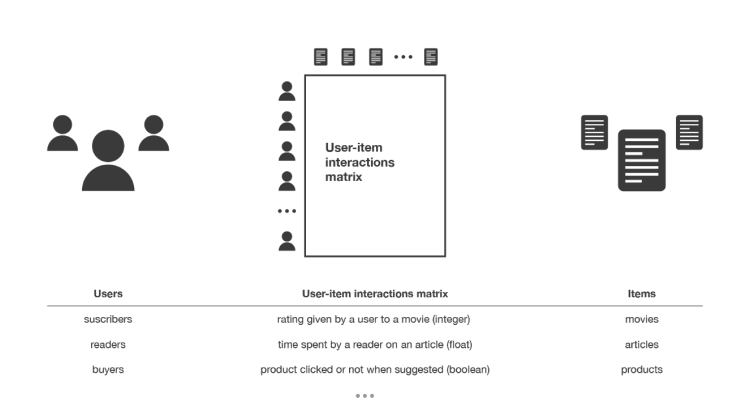

In [200]:
for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        print(matrix[i][j], end="  ")
    print()

6  0  0  6  0  0  0  0  8  0  
0  10  7  8  8  0  0  0  0  0  
7  9  2  0  0  8  0  0  6  4  
8  6  7  0  0  9  8  0  0  0  
8  0  0  0  0  0  10  7  8  0  
0  0  0  0  0  8  0  0  0  5  
0  0  0  0  8  9  10  0  0  0  
0  0  8  6  0  0  0  0  8  0  
4  0  0  0  0  0  0  0  0  9  
0  0  0  4  4  0  0  5  7  0  


The model is created in the cell below. It follows the steps described in the "Scalable Recommendation with Poisson Factorization" paper that was given as a reference. The Poisson distribution observes the initial matrix.
We use the Metropolis step, which takes into consideration the first four distributions, and trace the steps.

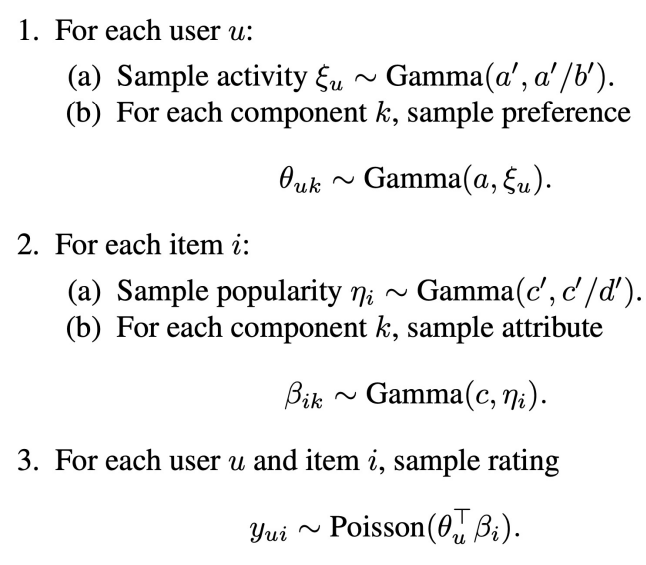

In [118]:
with pm.Model() as HPF:
    activity = pm.Gamma("activity", alpha=0.3, beta=0.3, shape=no_users)
    popularity = pm.Gamma("popularity", alpha=0.3, beta=0.3, shape=no_rest)

    preference = pm.Gamma("preference", alpha=0.3, beta=activity[:, None], shape=(no_users, no_latent_factors))
    attribute = pm.Gamma("attribute", alpha=0.3, beta=popularity[:, None], shape=(no_rest, no_latent_factors))

    rating = pm.Poisson("rating", mu=pm.math.dot(preference, attribute.T), observed = matrix)

    step = pm.Metropolis()
    trace = pm.sample(50, step=step, tune=50)

Only 50 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [activity]
>Metropolis: [popularity]
>Metropolis: [preference]
>Metropolis: [attribute]


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 422 seconds.
The number of samples is too small to check convergence reliably.


In [119]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
activity[0],0.636,0.428,0.023,1.468,0.090,0.064,17.0,24.0,1.19
activity[1],0.166,0.135,0.010,0.376,0.023,0.017,24.0,27.0,1.11
activity[2],0.259,0.263,0.004,0.767,0.077,0.056,11.0,12.0,1.31
activity[3],0.241,0.168,0.015,0.558,0.027,0.019,55.0,73.0,1.08
activity[4],0.337,0.390,0.016,0.766,0.110,0.079,9.0,30.0,1.48
...,...,...,...,...,...,...,...,...,...
"attribute[9, 0]",1.353,1.021,0.004,2.949,0.449,0.337,6.0,38.0,2.15
"attribute[9, 1]",0.070,0.194,0.000,0.235,0.042,0.030,9.0,14.0,1.46
"attribute[9, 2]",0.751,1.451,0.000,4.508,0.639,0.480,6.0,16.0,1.97
"attribute[9, 3]",0.050,0.073,0.000,0.223,0.021,0.015,9.0,16.0,1.40


We extract the latent vectors  and plot the weight of each feature in the latent vectors for each user, for a visualisation of importance.

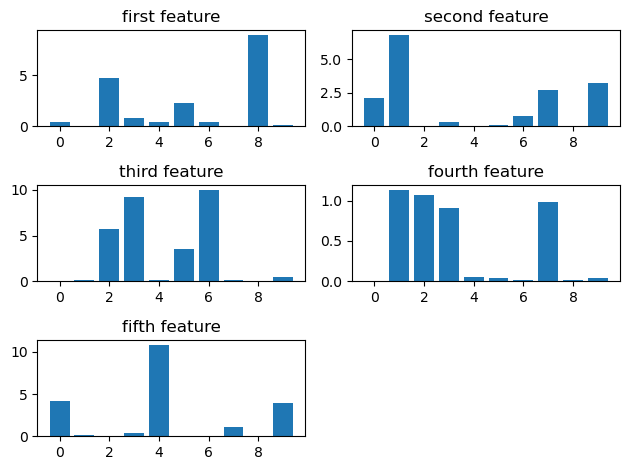

In [181]:
users_samples = np.mean(trace["posterior"]['preference'][1][:], axis=0)
rest_samples = np.mean(trace["posterior"]['attribute'][1][:], axis=0)

first_feature = list(zip(*users_samples))[0]
second_feature = list(zip(*users_samples))[1]
third_feature = list(zip(*users_samples))[2]
fourth_feature = list(zip(*users_samples))[3]
fifth_feature = list(zip(*users_samples))[4]

figure, axis = plt.subplots(3, 2)

axis[0, 0].bar(np.arange(10), first_feature)
axis[0, 0].set_title("first feature")

axis[0, 1].bar(np.arange(10), second_feature)
axis[0, 1].set_title("second feature")

axis[1, 0].bar(np.arange(10), third_feature)
axis[1, 0].set_title("third feature")

axis[1, 1].bar(np.arange(10), fourth_feature)
axis[1, 1].set_title("fourth feature")

axis[2, 0].bar(np.arange(10), fifth_feature)
axis[2, 0].set_title("fifth feature")

axis[2, 1].axis('off')
figure.tight_layout()
plt.show()

With the previous latent vectors we calculate the predicted ratings. The comparison between the true ratings and the predicted ones is presented below, along with the Mean Squared Error.

Mean Squared Error: 4.203172540837542


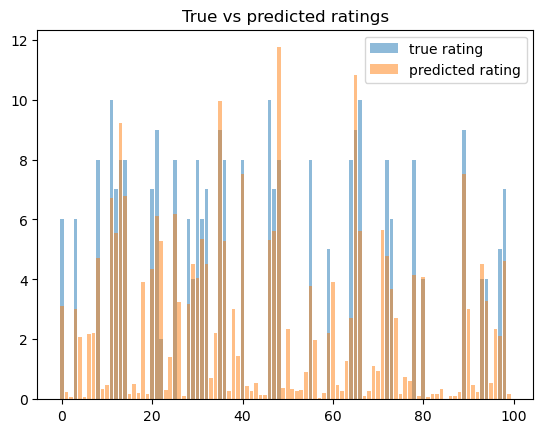

In [214]:
predicted_ratings = np.dot(users_samples, rest_samples.T)

mse = np.mean((matrix - predicted_ratings)**2)
print(f"Mean Squared Error: {mse}")

matrix_count = np.array(matrix).flatten()
ratings_count = np.array(predicted_ratings).flatten()

plt.bar(np.arange(len(matrix_count)), matrix_count, alpha=0.5, label = "true rating")
plt.bar(np.arange(len(matrix_count)), ratings_count, alpha=0.5, label = "predicted rating")
plt.legend()
plt.title("True vs predicted ratings")
figure.tight_layout()
plt.show()


Recommendation.

For a chosen user, list the top most liked restaurants and list the top recommendations, taken from the predicted data.

Since you liked:
Restaurant los Compadres
puesto de tacos
El Rinc�n de San Francisco

You should try the following restaurants:
Taqueria EL amigo 
carnitas_mata
little pizza Emilio Portes Gil


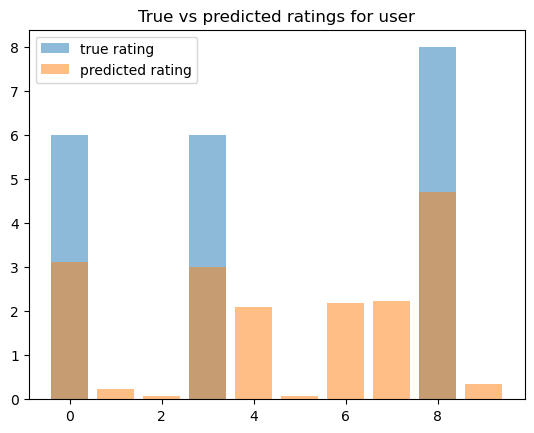

In [213]:
user = 2

recs = []
for index in range(no_rest):
    recs.append((predicted_ratings[user][index], index))

sorted_recs = sorted(recs, reverse = True)

print("Since you liked:")
no_recs = 3
for index in range(no_rest):
    if no_recs > 0:
        if matrix[user][sorted_recs[index][1]] != 0:
            print(names[sorted_recs[index][1]])
            no_recs -=1

print()
print("You should try the following restaurants:")
no_recs = 3
for index in range(no_rest):
    if no_recs > 0:
        if matrix[user][sorted_recs[index][1]] == 0:
            print(names[sorted_recs[index][1]])
            no_recs -=1

matrix_count = np.array(matrix).flatten()[:10]
ratings_count = np.array(predicted_ratings).flatten()[:10]

plt.bar(np.arange(len(matrix_count)), matrix_count, alpha=0.5, label = "true rating")
plt.bar(np.arange(len(matrix_count)), ratings_count, alpha=0.5, label = "predicted rating")
plt.legend()
plt.title("True vs predicted ratings for user")
figure.tight_layout()
plt.show()

In [208]:
train = pm.sample_posterior_predictive(trace, HPF)

Sampling: [rating]


Accuracy:

In [209]:
print(np.mean(matrix == train['posterior_predictive']) * 100)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    rating   float64 40.14


array([[<Axes: title={'center': 'activity'}>,
        <Axes: title={'center': 'activity'}>],
       [<Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'popularity'}>],
       [<Axes: title={'center': 'preference'}>,
        <Axes: title={'center': 'preference'}>],
       [<Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'attribute'}>]], dtype=object)

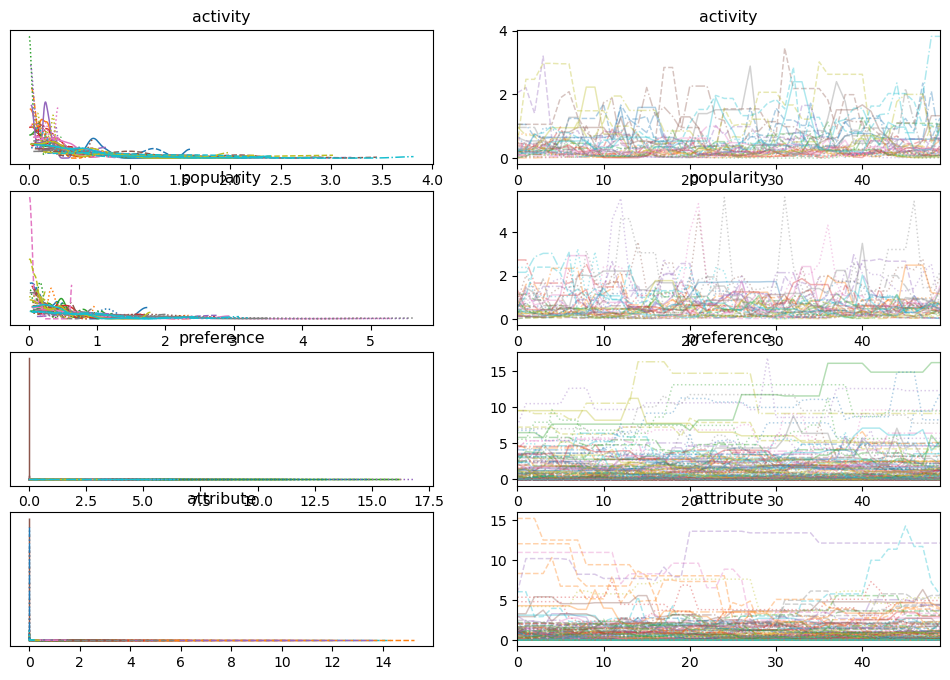

In [185]:
az.plot_trace(trace.posterior)